In [1]:
import numpy as np
import pandas as pd
import re
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import optuna
import torch
from torch.autograd import Variable
from torchviz import make_dot

torch.manual_seed(0)


## Loading dataset

In [2]:
x_train = pd.read_csv(
    "../data/processed/x_train_w_OHE.csv", index_col=0, dtype=str
)
x_test = pd.read_csv(
    "../data/processed/x_test_w_OHE.csv", index_col=0, dtype=str
)
y_train = pd.read_csv(
    "../data/processed/y_train.csv", index_col=0, dtype=float
).squeeze("columns").reset_index(drop=True)
y_test = pd.read_csv(
    "../data/processed/y_test.csv", index_col=0, dtype=float
).squeeze("columns").reset_index(drop=True)

x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42)

zip_cols = x_train.columns[
    [re.search('zip_is', col) is not None for col in x_train.columns]
]


In [3]:
def get_correct_types_x(df, numeric_cols):
    for col in ['deenergize_time', 'restoration_time']:
        df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S')
    for col in numeric_cols:
        df[col] = df[col].astype(float)
    return df


numeric_cols = [
    'hftd_tier', 'total_affected', 'residential_affected',
    'longitude', 'latitude', 'total_pop', 'median_age', 'median_income',
    'white_pct', 'tmin_d-5', 'tmax_d-5', 'wspd_d-5', 'tmin_d-4', 'tmax_d-4',
    'wspd_d-4', 'tmin_d-3', 'tmax_d-3', 'wspd_d-3', 'tmin_d-2', 'tmax_d-2',
    'wspd_d-2', 'tmin_d-1', 'tmax_d-1', 'wspd_d-1', 'day_in_year'
]
x_train = get_correct_types_x(x_train, numeric_cols)
x_valid = get_correct_types_x(x_valid, numeric_cols)
x_test = get_correct_types_x(x_test, numeric_cols)
rel_x_train = x_train[numeric_cols]
rel_x_valid = x_valid[numeric_cols]
rel_x_test = x_test[numeric_cols]

scaler = StandardScaler()
scaler.fit(rel_x_train)
scaled_x_train = scaler.transform(rel_x_train)
scaled_x_valid = scaler.transform(rel_x_valid)
scaled_x_test = scaler.transform(rel_x_test)


## Defining the Neural Network Model

In [34]:
class base_model(torch.nn.Module):

    def __init__(self, n_hidden_layers, n_hidden_units, p=0.1, activation=torch.nn.ReLU()):
        super(base_model, self).__init__()
        if n_hidden_layers == 0:
            self.linears = torch.nn.ModuleList([
                torch.nn.Linear(scaled_x_train.shape[1], 1)
            ])
            self.activation = activation
            self.dropout = torch.nn.Dropout(p)
        else:
            assert len(n_hidden_units) == n_hidden_layers
            self.layers = []

            for layer, n_units in enumerate(n_hidden_units):
                if layer == 0:
                    curr_layer = torch.nn.Linear(
                        scaled_x_train.shape[1], n_units)
                else:
                    curr_layer = torch.nn.Linear(
                        n_hidden_units[layer - 1], n_units)
                self.layers.append(curr_layer)
            self.layers.append(torch.nn.Linear(n_hidden_units[-1], 1))
            self.linears = torch.nn.ModuleList(self.layers)
            self.activation = activation
            self.dropout = torch.nn.Dropout(p)

    def forward(self, x):
        for layer in self.linears:
            x = self.dropout(self.activation(layer(x)))
        return x


## Hyper-parameter Optimization using Optuna

In [37]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 1. Define an objective function to be maximized.


def objective(trial):

    # 2. Suggest values of the hyperparameters using a trial object.
    n_layers = trial.suggest_int('n_layers', 0, 4)
    n_hidden_units = [0] * n_layers
    print(n_layers)
    for i in range(n_layers):
        n_hidden_units[i] = trial.suggest_int(f"n_h_{i}", 1, 50)
    lr = trial.suggest_float("lr", 1e-5, 5e-1, log=True)
    n_epochs = trial.suggest_int("n_epochs", 1000, 100000)
    activation_functions = [torch.nn.ReLU(), torch.nn.Tanh()]
    act_idx = trial.suggest_categorical("act_function", [0, 1])
    dropout_p = trial.suggest_float("dropout", 0, 1)
    params = f"""Params:
          n_layers: {n_layers}
          n_hidden_units: {n_hidden_units}
          lr: {lr}
          n_epochs: {n_epochs}
          act_function: {activation_functions[act_idx]}
          dropout: {dropout_p}"""
    print(params)

    x = torch.from_numpy(scaled_x_train).float().to(device)
    y = torch.from_numpy(y_train.values.reshape(-1, 1)).float().to(device)

    inputs = Variable(x)
    targets = Variable(y)

    # base = base_model(1, [1], activation=torch.nn.Tanh())
    base = base_model(n_layers, n_hidden_units, p=dropout_p,
                      activation=activation_functions[act_idx])
    base.to(device)
    optimizer = torch.optim.Adagrad(base.parameters(), lr=lr)
    loss_func = torch.nn.MSELoss()
    prev_loss = torch.from_numpy(np.array([0])).to(device)

    for i in range(n_epochs):
        prediction = base(inputs)
        loss = loss_func(prediction, targets)
        if i % 1000 == 0:
            print(loss)
        if np.abs(loss.cpu().detach().numpy() - prev_loss.cpu().detach().numpy()) < 1e-8:
          break
        prev_loss = loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    valid_x = Variable(torch.from_numpy(scaled_x_valid).float()).to(device)
    valid_y = Variable(torch.from_numpy(
        y_valid.values.reshape(-1, 1)).float()).to(device)
    valid_predictions = base(valid_x)
    loss = loss_func(valid_predictions, valid_y)
    print(f"Final valid loss: {loss}")
    print("#################")
    if loss < 1000000:
      with open(f"gdrive/MyDrive/CS229_Final_Project/nn_hpo/run_2/{time.time()}.txt", "w+") as f:
        f.write(f"Loss: {np.sqrt(loss.cpu().detach().numpy())}\n")
        f.write(params)
    return np.sqrt(loss.cpu().detach().numpy())


In [38]:
# 3. Create a study object and optimize the objective function.
torch.manual_seed(0)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
pd.DataFrame.from_dict({"value": study.best_trial.values, "params": str(
    study.best_trial.params)}).to_csv("gdrive/MyDrive/CS229_Final_Project/nn_hpo/run_4.csv", index=False)

# fig = optuna.visualization.plot_optimization_history(study)
# fig.show()
# fig.write_image("gdrive/MyDrive/CS229_Final_Project/nn_hpo/run_1.png")


## Running best models on test data

In [39]:
# Load best hyperparams
best_params = pd.read_csv("nn_hpo/run_1.csv")
best_params_dict = eval(best_params["params"].values[0])
best_params_dict


{'n_layers': 2,
 'n_h_0': 46,
 'n_h_1': 96,
 'lr': 0.011578444404576697,
 'n_epochs': 44718,
 'act_function': 0,
 'dropout': 0.05}

### Baseline Model

In [ ]:
x = torch.from_numpy(scaled_x_train).float()
y = torch.from_numpy(y_train.values.reshape(-1, 1)).float()

inputs = Variable(x)
targets = Variable(y)

base = base_model(1, [20])
print(base)
optimizer = torch.optim.Adagrad(base.parameters())
loss_func = torch.nn.MSELoss()

for i in range(100000):
   prediction = base(inputs)
   loss_base = loss_func(prediction, targets)
   if i % 1000 == 0:
      print(loss_base)
   optimizer.zero_grad()
   loss_base.backward()
   optimizer.step()

In [41]:
# Baseline loss
test_x = Variable(torch.from_numpy(scaled_x_test).float())
test_y = Variable(torch.from_numpy(y_test.values.reshape(-1, 1)).float())
test_predictions_base = base(test_x)
loss_base = loss_func(test_predictions_base, test_y)
baseline_rmse = np.sqrt(loss_base.detach().numpy())
baseline_rmse


1625.2429

### Model with best hyperparameters

In [ ]:
x = torch.from_numpy(scaled_x_train).float()
y = torch.from_numpy(y_train.values.reshape(-1, 1)).float()

inputs = Variable(x)
targets = Variable(y)

best = base_model(best_params_dict["n_layers"], 
                  [46, 96],
                  # best_params_dict["n_hidden_units"], 
                  # activation=best_params_dict["act_function"],
                  p=best_params_dict["dropout"]
)
print(best)
optimizer = torch.optim.Adagrad(best.parameters(), lr=best_params_dict["lr"])
loss_func = torch.nn.MSELoss()

for i in range(best_params_dict["n_epochs"]):
   prediction = best(inputs)
   loss = loss_func(prediction, targets)
   if i % 1000 == 0:
      print(loss)
   optimizer.zero_grad()
   loss.backward()
   optimizer.step()


In [43]:
# Best model loss
test_predictions = best(test_x)
loss = loss_func(test_predictions, test_y)
best_rmse = np.sqrt(loss.detach().numpy())
best_rmse

1081.0851

## Model Visualization

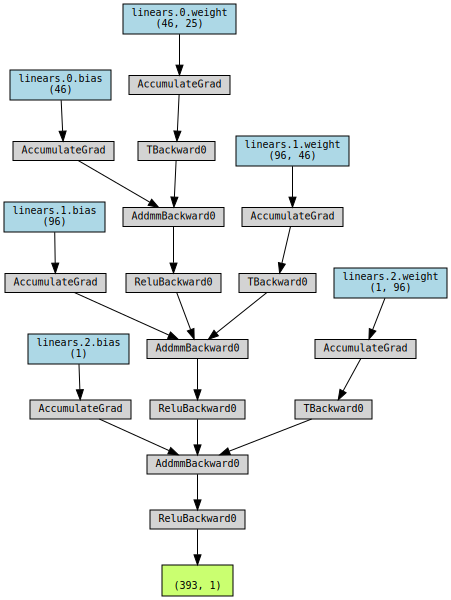

In [19]:
make_dot(test_predictions, params=dict(best.named_parameters()))


## Evaluation Metrics

In [14]:
def calc_test_r2(pred_vals, true_vals, baseline_rmse):
    sse = mean_squared_error(pred_vals, true_vals) * len(true_vals)
    sst = (baseline_rmse ** 2) * len(true_vals)
    return (
        1 - sse / sst, np.sqrt(sse / len(true_vals)),
        mean_absolute_error(pred_vals, true_vals)
    )


In [21]:
calc_test_r2(test_predictions.detach().numpy(), y_test.values.reshape(-1, 1), np.sqrt(np.var(y_test)))

(0.7087489089518462, 852.6837065281679, 600.8200379971026)

## Error Analysis

In [16]:
test_predictions_np = test_predictions.detach().numpy()


In [17]:
np.max((test_predictions_np - y_test.values.reshape(-1, 1)) ** 2)

18766839.538250506

In [18]:
largest_error = np.argmax((test_predictions_np - y_test.values.reshape(-1, 1)) ** 2)
largest_error

183

In [19]:
x_test.iloc[largest_error, :]

circuit_name                  WYANDOTTE
deenergize_time     2020-09-07 22:20:00
restoration_time    2020-09-13 08:52:00
key_communities                OROVILLE
hftd_tier                           3.0
                           ...         
zip_is_96073                        0.0
zip_is_96076                        0.0
zip_is_96080                        0.0
zip_is_96096                        0.0
zip_is_96137                        0.0
Name: 1221, Length: 285, dtype: object